In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import re

抓股票代號

In [79]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [80]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(42)
US10_Stocks = random.sample(US100_stocks, 10)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y")
    US10_stocks_prices[stock] = historical_data

In [81]:
US10_Stocks

['ADP', 'JNJ', 'AMZN', 'ETN', 'CMCSA', 'MCD', 'CSCO', 'AVGO', 'JPM', 'CVS']

利用股價生成日報酬

In [82]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [83]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)

In [84]:
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]
US10_stocks_expected_return

f = np.array([US10_stocks_expected_return[stock] for stock in US10_stocks_expected_return]).T
f

array([ 0.2380982 ,  0.03705568, -0.22913847,  0.44857714, -0.159515  ,
        0.13635515,  0.01072739,  0.74680516, -0.06954902, -0.10900864])

開始計算protfolio_variance

In [85]:
from collections import Counter

#將收益率陣列長度不等於最長天數的股票刪除
def returns_length_reshape(stocks_returns):
    length = []
    for stock in stocks_returns:
        length.append(len(stocks_returns[stock]))
    max_length = Counter(length).most_common(1)[0][0]
    to_del = []
    for stock in stocks_returns:
        if len(stocks_returns[stock]) != max_length:
            #print(f'{stock} 的收益率陣列長度只有 {len(stocks_returns[stock])} 天，不等於最長天數 {max_length}')
            to_del.append(stock)

    #刪除收益率陣列長度不等於最長天數的股票
    for stock in to_del:
        del stocks_returns[stock]

#透過日報酬計算個股標準差
def standard_deviation_matrix(stocks_returns):
    returns = dict(stocks_returns)
    stocks_std = []
    for stock in returns:
        stocks_std.append(np.std(returns[stock]))
    return np.diag(stocks_std)

#計算相關係數矩陣
def correlation_matrix(stocks_returns):
    temp_dict = dict(stocks_returns)     
    size = len(temp_dict)
    correlation_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i+1, size):
            correlation = np.corrcoef(temp_dict[list(temp_dict.keys())[i]], temp_dict[list(temp_dict.keys())[j]])[0][1]
            correlation_matrix[i][j] = correlation
            correlation_matrix[j][i] = correlation
    np.fill_diagonal(correlation_matrix, 1)
    return correlation_matrix

#計算共變異數矩陣
def V_matrix(stocks_returns):
    V = np.dot(np.dot(standard_deviation_matrix(stocks_returns), correlation_matrix(stocks_returns)), standard_deviation_matrix(stocks_returns))
    return V

In [86]:
#計算有N個組成的投組的變異數
def get_variance_of_protfolio(V, N):
    avg_of_stocks_variance = np.sum(np.diag(V)) / N
    avg_of_stocks_covariance = np.sum([V[i, j] for i in range(min(V.shape)) for j in range(min(V.shape)) if i != j]) / (N * (N - 1) / 2)
    
    variance_of_protfolio = 1 / N * avg_of_stocks_variance + (N - 1) / N * avg_of_stocks_covariance
    # sd = np.sqrt(variance_of_protfolio)

    return variance_of_protfolio

In [87]:
def get_fp(h, f):
    return h.T @ f

def variance_p(h, v):
    return h.T @ v @ h

In [88]:
# 設置要生成的組數
num_samples = 1000000

# 每組數字的數量
num_digits = len(US10_stocks_returns)

# 用來存儲生成的結果的列表
results = []

# 生成兩千組數字
for _ in range(num_samples):
    # 生成10個隨機數字
    random_numbers = [random.random() for _ in range(num_digits)]
    
    # 計算總和
    total = sum(random_numbers)
    
    # 將數字標準化，使總和為1
    normalized_numbers = [num / total for num in random_numbers]
    
    # 添加到結果列表中
    results.append(normalized_numbers)

# 打印前5組數字作為示例
for i in range(5):
    print(f"組數字 {i+1}: {results[i]}")


組數字 1: [0.15381632435058198, 0.11325763306005318, 0.12262905800252469, 0.006600388596770987, 0.019457924971638427, 0.04831727005682308, 0.12502273625298074, 0.11655516695932615, 0.148697585139294, 0.14564591261000673]
組數字 2: [0.09092362814808132, 0.09735825161119192, 0.060292999866930895, 0.18840573238137476, 0.16445830551409663, 0.0346033812642096, 0.09159432395745157, 0.06022378271721725, 0.0466655148644909, 0.1654740796749551]
組數字 3: [0.03320250406938036, 0.123417509226973, 0.1166126807126865, 0.11173231952930837, 0.08592829869381427, 0.014114662019237915, 0.14924190557215325, 0.04054916316848014, 0.2996031014258035, 0.02559785558216254]
組數字 4: [0.051384127816085326, 0.11017906119262504, 0.15518941434745823, 0.06338225436806766, 0.03370161477140042, 0.012190639225636287, 0.11589684856018098, 0.13549244590358023, 0.17267564398638144, 0.14990794982858455]
組數字 5: [0.16730710289111564, 0.07339759522807228, 0.08754782925605141, 0.16105623721116458, 0.031406461324839624, 0.068598305862760

In [89]:
fp_array = []
p_var_array = []
for result in results:
    h = np.array(result).T
    v = V_matrix(US10_stocks_returns)
    fp_array.append(get_fp(h, f))
    p_var_array.append(variance_p(h, v))

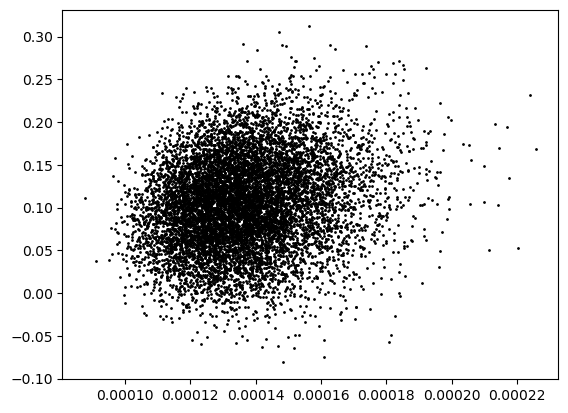

In [90]:
plt.plot(p_var_array, fp_array, 'o', color='black', markersize=1)